# ODE Prior - Parameter Estimation
In this tutorial, we look at the ODE prior for the Lorenz-63 model using the weak-constrained formulation.
The difference between this tutorial and the previous one is that we will use the `jaxopt` library to compute the gradients.


In [1]:
import os, sys

jaxsw_path = "/Users/eman/code_projects/jaxsw"
sys.path.append(jaxsw_path)

In [2]:
import autoroot  # noqa: F401, I001
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import diffrax as dfx
import equinox as eqx
import xarray as xr

from jaxsw import L63State, Lorenz63, rhs_lorenz_63

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Lorenz 63

* Equation of Motion
* Observation Operator
* Integrate

### Equation of Motion

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma (y - x) \\
\frac{dy}{dt} &= x (\rho - z) - y \\
\frac{dz}{dt} &= xy - \beta z
\end{aligned}
$$

where $(\sigma,\rho,\beta)$ are hyperparameters.

## Simulation

In [3]:
ds_sol = xr.open_dataset("./data/sim_l63.nc")
ds_sol

<xarray.Dataset>
Dimensions:              (time: 200, component: 3, realization: 1000)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation           (component, realization, time) float32 ...
    observations         (component, realization, time) float32 ...
    observations_noise   (component, realization, time) float64 ...
    observations_interp  (component, realization, time) float64 ...

## Inverse Problem

In [4]:
realization = 100

ds_trajectory = ds_sol.sel(realization=realization)
ds_trajectory

<xarray.Dataset>
Dimensions:              (time: 200, component: 3)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Data variables:
    simulation           (component, time) float32 ...
    observations         (component, time) float32 ...
    observations_noise   (component, time) float64 ...
    observations_interp  (component, time) float64 ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


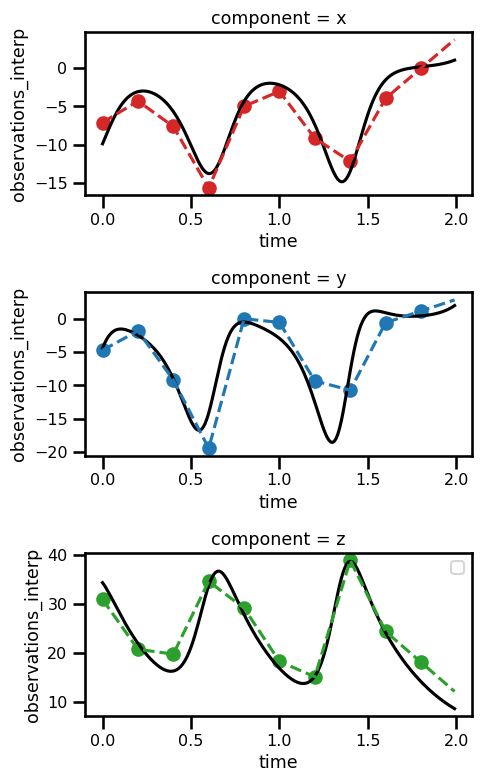

In [5]:
fig, ax = plt.subplots(nrows=3, figsize=(5, 8))


ds_trajectory.simulation.sel(component="x").plot(ax=ax[0], color="black")
ds_trajectory.simulation.sel(component="y").plot(ax=ax[1], color="black")
ds_trajectory.simulation.sel(component="z").plot(ax=ax[2], color="black")

ds_trajectory.observations_noise.sel(component="x").plot.scatter(
    ax=ax[0], color="tab:red"
)
ds_trajectory.observations_noise.sel(component="y").plot.scatter(
    ax=ax[1], color="tab:blue"
)
ds_trajectory.observations_noise.sel(component="z").plot.scatter(
    ax=ax[2], color="tab:green"
)

ds_trajectory.observations_interp.sel(component="x").plot(
    ax=ax[0], color="tab:red", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="y").plot(
    ax=ax[1], color="tab:blue", linestyle="--"
)
ds_trajectory.observations_interp.sel(component="z").plot(
    ax=ax[2], color="tab:green", linestyle="--"
)

# ax.set_xlabel("Time")
# ax.set_ylabel("Values")
# ax.set_title(f"Trajectory")


plt.legend()
plt.tight_layout()
plt.show()

## Data

For this problem we need the following variables

**True State**: $\boldsymbol{u}$

**Time Steps**: $\boldsymbol{\Tau}$

**Observations**: $\boldsymbol{y}$

**Initial State**: $\boldsymbol{u}^{(k)}$

**Mask**: $\boldsymbol{m}$

In [6]:
# Ground Truth
x_state = jnp.asarray(ds_trajectory.simulation.values).T
ts_state = jnp.asarray(ds_trajectory.time.values)
# Observations
y_gt = jnp.asarray(ds_trajectory.observations_noise.values).T
# Mask
y_mask = 1.0 - (
    jnp.isnan(jnp.asarray(ds_trajectory.observations_noise.values))
    .astype(jnp.float32)
    .T
)
# initialization
x_init = jnp.asarray(ds_trajectory.observations_interp.values).T

x_state.shape, y_gt.shape, y_mask.shape, x_init.shape

((200, 3), (200, 3), (200, 3), (200, 3))

## Dynamical Prior

Here, we define our dynamical prior which we plug into this loss function.

$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
||\boldsymbol{u} - \boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta})||_2^2
$$

Our dynamical prior in this case is defined by:

$$
\boldsymbol{\phi}(\boldsymbol{u};\boldsymbol{\theta}) \coloneqq
\boldsymbol{u}(t_1) =
\boldsymbol{u}(t_0) + \int_{t_0}^{t_1}
\boldsymbol{F}\left( \boldsymbol{u}(t),\tau;\boldsymbol{\theta}\right)d\tau 
$$



**Weak Constrained**

The weak-constrained version works as a "one-step" prediction whereby we step through the trajectory with the ODE solver one at a time.


$$
\mathbf{R}(\boldsymbol{u};\boldsymbol{\theta}) =
\frac{\lambda}{2}
\sum_{t=0}^T
||\boldsymbol{u}_t - \boldsymbol{\phi}(\boldsymbol{u}_t;\boldsymbol{\theta})||_2^2
$$

In [7]:
from jejeqx._src.fourdvar.priors.dynamical import Weak4DVar, Strong4DVar
from jaxsw import L63State, L63Params

In [28]:
import equinox as eqx
import typing as tp
from jaxtyping import Array, PyTree
from jejeqx._src.fourdvar.utils import time_patches
import typing as tp
import equinox as eqx
import diffrax as dfx
import jax
import jax.numpy as jnp
from jaxtyping import PyTree, Array
from jejeqx._src.fourdvar.utils import time_patches
from jejeqx._src.fourdvar.priors.base import Prior

Solver = dfx.AbstractSolver
StepSize = dfx.AbstractAdaptiveStepSizeController
Adjoint = dfx.AbstractAdjoint


class Func(eqx.Module):
    sigma: jnp.ndarray #= eqx.static_field()
    rho: jnp.ndarray #= eqx.static_field()
    beta: jnp.ndarray
    def __init__(
        self,
        sigma: float=10., 
        rho: float=8., 
        beta: float=2.333,
    ):
        # self.sigma = jnp.asarray(sigma)
        # self.rho = jnp.asarray(rho)
        # self.beta = jnp.asarray(beta)
        self.sigma = jnp.asarray(sigma)
        self.rho = jnp.asarray(rho)
        self.beta = jnp.asarray(beta)
    def __call__(self, t, y, args):
        x, y, z = y
        x_dot, y_dot, z_dot = rhs_lorenz_63(
            x=x, y=y, z=z, 
            # sigma=jnp.exp(self.sigma), 
            # rho=jnp.exp(self.rho), 
            # beta=jnp.exp(self.beta)
            sigma=self.sigma, 
            rho=self.rho, 
            beta=self.beta
            )
        return jnp.stack([x_dot, y_dot, z_dot], axis=0)


class Model(eqx.Module):
    model: eqx.Module
    solver: Solver
    stepsize: StepSize
    adjoint: Adjoint

    def __init__(
        self,
        model: tp.Callable,
        solver: Solver = dfx.Tsit5(),
        stepsize: StepSize = dfx.PIDController(rtol=1e-5, atol=1e-5),
        adjoint: Adjoint = dfx.RecursiveCheckpointAdjoint(),
    ):

        self.model = model
        self.solver = solver
        self.stepsize = stepsize
        self.adjoint = adjoint

    def __call__(
        self,
        x: Array,
        ts: Array,
    ) -> PyTree:
        t0 = ts[0]
        t1 = ts[-1]

        # time step
        dt = ts[1] - ts[0]

        # initialize state

        saveat = dfx.SaveAt(ts=jnp.asarray([t1]))

        sol = dfx.diffeqsolve(
            terms=dfx.ODETerm(self.model),
            solver=self.solver,
            t0=t0,
            t1=t1,
            dt0=dt,
            y0=x,
            saveat=saveat,
            args=None,
            stepsize_controller=self.stepsize,
        )

        return sol.ys
    


In [29]:
jnp.log(10)

Array(2.3025851, dtype=float32, weak_type=True)

In [30]:
rhs_fn = Func(sigma=30., rho=35., beta=0.1)
out = rhs_fn(0, x_state[0], None)
out.shape, x_state[0].shape

((3,), (3,))

In [31]:

model = Model(model=rhs_fn)
ts_patches = time_patches(ts_state)
out = model(x_state[0], ts_patches[0])

out_batches = jax.vmap(model, in_axes=(0,0))(x_state[:-1], ts_patches)
out.shape, out_batches.shape

((1, 3), (199, 1, 3))

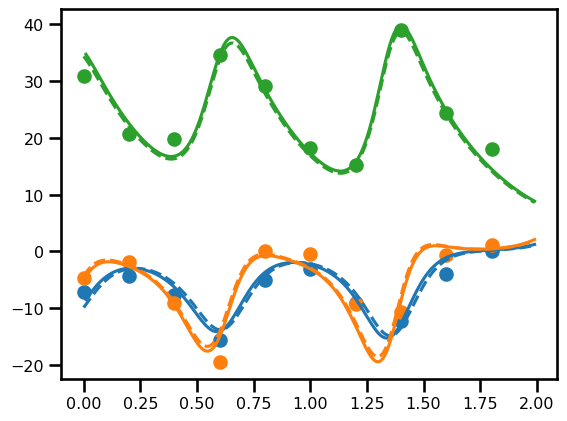

In [32]:
fig, ax = plt.subplots()

ax.plot(ts_state[1:], out_batches[..., 0].squeeze(), linestyle="-", color="tab:blue")
ax.plot(ts_state, x_state[..., 0].squeeze(), linestyle="--", color="tab:blue")
ax.scatter(ts_state, y_gt[..., 0], color="tab:blue")
ax.plot(ts_state[1:], out_batches[..., 1].squeeze(), linestyle="-", color="tab:orange")
ax.plot(ts_state, x_state[..., 1].squeeze(), linestyle="--", color="tab:orange")
ax.scatter(ts_state, y_gt[..., 1], color="tab:orange")
ax.plot(ts_state[1:], out_batches[..., 2].squeeze(), linestyle="-", color="tab:green")
ax.plot(ts_state, x_state[..., 2].squeeze(), linestyle="--", color="tab:green")
ax.scatter(ts_state, y_gt[..., 2],  color="tab:green")

In [33]:
import optax

In [34]:

def mse_loss(x, y, mask):
    return 

In [35]:
@eqx.filter_value_and_grad
def grad_loss(model, x, ts, y, mask):

    y_pred = jax.vmap(model, in_axes=(0,0))(x[:-1], ts)
    constant = 1/0.1**2
    # print(y_pred.shape, y.shape, mask.shape)
    # print(jnp.nan_to_num(y).min(), jnp.nan_to_num(y).max())
    return jnp.mean(mask * (y_pred.squeeze() - jnp.nan_to_num(y)) ** 2)

# rhs_fn = Func(sigma=10, rho=28, beta=1.1)
rhs_fn = Func(sigma=20., rho=15., beta=1.1)
model = Model(model=rhs_fn)
loss, grads = grad_loss(model, x_state, ts_patches, y_gt[1:], y_mask[1:])

In [36]:
# loss

In [37]:
# grads

In [38]:
lr = 1e-3
optim = optax.adam(lr)

@eqx.filter_jit
def make_step(x, ts, y, y_mask, model, opt_state):
    loss, grads = grad_loss(model, x, ts, jnp.nan_to_num(y[1:]), y_mask[1:])
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [39]:
x_state.shape,ts_patches.shape,  y_gt[1:].shape, y_mask[1:].shape

((200, 3), (199, 2), (199, 3), (199, 3))

In [40]:
# # train_time_steps = 50

# # opt_state = optim.init(eqx.filter(model, eqx.is_array))
# # loss, model, opt_state = make_step(
# #     x_state, ts_patches, y_gt, y_mask, model, opt_state)

# train_time_steps = 50

# rhs_fn = Func(sigma=100, rho=100, beta=1.1)
# model = Model(model=rhs_fn)
# loss, grads = grad_loss(model, x_state, ts_patches, y_gt[1:], y_mask[1:])

# opt_state = optim.init(eqx.filter(model, eqx.is_array))
# loss, model, opt_state = make_step(
#     x_state[:train_time_steps], 
#     ts_patches[:train_time_steps-1], 
#     y_gt[:train_time_steps], 
#     # x_state[1:],
#     y_mask[:train_time_steps],
#     # 1.0, 
#     model, 
#     opt_state
#     )

In [41]:
from tqdm.notebook import trange, tqdm


losses = list()
rhs_fn = Func(sigma=20., rho=15., beta=1.1)
model = Model(model=rhs_fn)
loss, grads = grad_loss(model, x_state, ts_patches, y_gt[1:], y_mask[1:])
opt_state = optim.init(eqx.filter(model, eqx.is_array))
with trange(10_000) as pbar:

    for i in pbar:

        if i < 1_000:
            train_time_steps = 50
        elif i < 5_000:
            train_time_steps = 100
        elif i < 7_000:
            train_time_steps = 150
        else:
            train_time_steps = 200

        loss, model, opt_state = make_step(
            x_state[:train_time_steps], 
            ts_patches[:train_time_steps-1], 
            y_gt[:train_time_steps], 
            # x_state[1:50],
            y_mask[:train_time_steps],
            # 1.0, 
            model, 
            opt_state
        )

        pbar.set_description(f"Loss: {loss:.3e}")
        losses.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

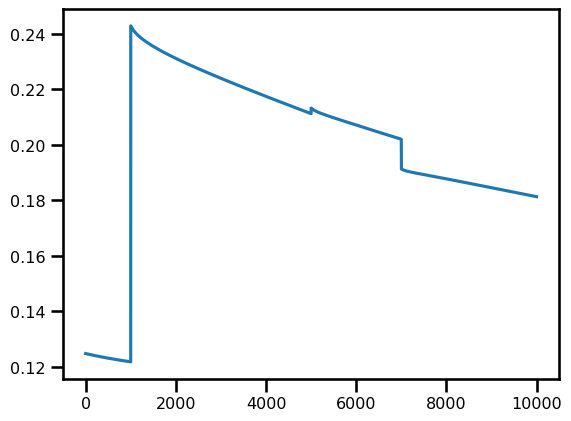

In [42]:
plt.plot(losses)

In [43]:
out_batches = jax.vmap(model, in_axes=(0,0))(x_state[:-1], ts_patches)
out_batches.shape

(199, 1, 3)

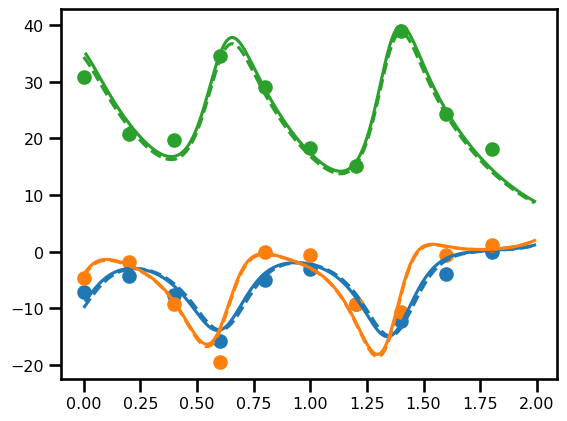

In [44]:
fig, ax = plt.subplots()

ax.plot(ts_state[1:], out_batches[..., 0].squeeze(), linestyle="-", color="tab:blue")
ax.plot(ts_state, x_state[..., 0].squeeze(), linestyle="--", color="tab:blue")
ax.scatter(ts_state, y_gt[..., 0], color="tab:blue")
ax.plot(ts_state[1:], out_batches[..., 1].squeeze(), linestyle="-", color="tab:orange")
ax.plot(ts_state, x_state[..., 1].squeeze(), linestyle="--", color="tab:orange")
ax.scatter(ts_state, y_gt[..., 1], color="tab:orange")
ax.plot(ts_state[1:], out_batches[..., 2].squeeze(), linestyle="-", color="tab:green")
ax.plot(ts_state, x_state[..., 2].squeeze(), linestyle="--", color="tab:green")
ax.scatter(ts_state, y_gt[..., 2],  color="tab:green")

In [45]:
model.model.sigma, model.model.rho, model.model.beta

(Array(24.86107, dtype=float32),
 Array(25.104101, dtype=float32),
 Array(-0.47580832, dtype=float32))

In [33]:
jax.nn.softplus(model.model.sigma), jax.nn.softplus(model.model.rho), jax.nn.softplus(model.model.beta)

(Array(24.910973, dtype=float32),
 Array(25.104275, dtype=float32),
 Array(0.0291146, dtype=float32))

## Batches

In [31]:
ds_sol

<xarray.Dataset>
Dimensions:              (time: 200, component: 3, realization: 1000)
Coordinates:
  * time                 (time) float32 0.0 0.01 0.02 0.03 ... 1.97 1.98 1.99
  * component            (component) object 'x' 'y' 'z'
Dimensions without coordinates: realization
Data variables:
    simulation           (component, realization, time) float32 ...
    observations         (component, realization, time) float32 ...
    observations_noise   (component, realization, time) float64 ...
    observations_interp  (component, realization, time) float64 ...

In [32]:
# Ground Truth
x_state = jnp.asarray(ds_sol.simulation.transpose("realization", "time", "component").values)
ts_state = jnp.asarray(ds_sol.time.values)
# Observations
y_gt = jnp.asarray(ds_sol.observations_noise.transpose("realization", "time", "component").values)
# Mask
y_mask = 1.0 - (
    jnp.isnan(jnp.asarray(ds_sol.observations_noise.transpose("realization", "time", "component").values))
    .astype(jnp.float32)
    
)
# initialization
x_init = jnp.asarray(ds_sol.observations_interp.transpose("realization", "time", "component").values)

x_state.shape, y_gt.shape, y_mask.shape, x_init.shape

((1000, 200, 3), (1000, 200, 3), (1000, 200, 3), (1000, 200, 3))

In [33]:
x_state[0].shape, ts_patches.shape

((200, 3), (199, 2))

In [34]:

model = Model(model=rhs_fn)
ts_patches = time_patches(ts_state)
# out = model(x_state[0], ts_patches[0])

def batched_time_predict(x, ts):
    return jax.vmap(model, in_axes=(0, 0))(x, ts)
def batched_predict(x, ts):
    return jax.vmap(batched_time_predict, in_axes=(0, None))(x, ts)

out_batches = batched_predict(x_state[:, :-1], ts_patches)
out.shape, out_batches.shape

((1, 3), (1000, 199, 1, 3))

In [35]:
out_batches = jax.vmap(model, in_axes=(0,0))(x_state[0, :-1], ts_patches)
out_batches.shape, ts_state.shape

((199, 1, 3), (200,))

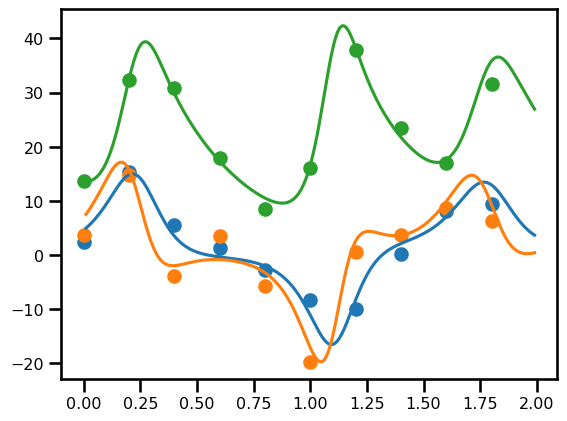

In [36]:
fig, ax = plt.subplots()

ax.plot(ts_state[1:], out_batches[..., 0].squeeze())
ax.scatter(ts_state, y_gt[0, ..., 0])
ax.plot(ts_state[1:], out_batches[..., 1].squeeze())
ax.scatter(ts_state, y_gt[0, ..., 1])
ax.plot(ts_state[1:], out_batches[..., 2].squeeze())
ax.scatter(ts_state, y_gt[0, ..., 2])

In [37]:
@eqx.filter_value_and_grad
def grad_loss(model, x, ts, y, mask):

    def batched_time_predict(x, ts):
        return jax.vmap(model, in_axes=(0, 0))(x, ts)
    def batched_predict(x, ts):
        return jax.vmap(batched_time_predict, in_axes=(0, None))(x, ts)

    y_pred = batched_predict(x[:, :-1], ts)
    constant = 1/0.1**2
    # print(y_pred.shape, y.shape, mask.shape)
    # print(jnp.nan_to_num(y).min(), jnp.nan_to_num(y).max())
    return jnp.mean(jnp.sum(mask * (y_pred.squeeze() - jnp.nan_to_num(y)) ** 2, axis=1))

# rhs_fn = Func(sigma=10., rho=28., beta=1.1)
rhs_fn = Func(sigma=20, rho=15, beta=1.1)
model = Model(model=rhs_fn)
loss, grads = grad_loss(model, x_state, ts_patches, y_gt[:, 1:], y_mask[:, 1:])

In [38]:
loss

Array(39.598503, dtype=float32)

In [41]:
lr = 1e-2
optim = optax.adam(lr)

@eqx.filter_jit
def make_step(x, ts, y, y_mask, model, opt_state):
    loss, grads = grad_loss(model, x, ts, jnp.nan_to_num(y[:, 1:]), y_mask[:, 1:])
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [42]:
opt_state = optim.init(eqx.filter(model, eqx.is_array))
loss, model, opt_state = make_step(x_state, ts_patches, y_gt, y_mask, model, opt_state)

In [43]:
from tqdm.notebook import trange, tqdm

losses = list()
with trange(5_000) as pbar:

    for i in pbar:

        loss, model, opt_state = make_step(x_state[:32], ts_patches, y_gt[:32], y_mask[:32], model, opt_state)

        pbar.set_description(f"Loss: {loss:.3f}")
        losses.append(loss)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

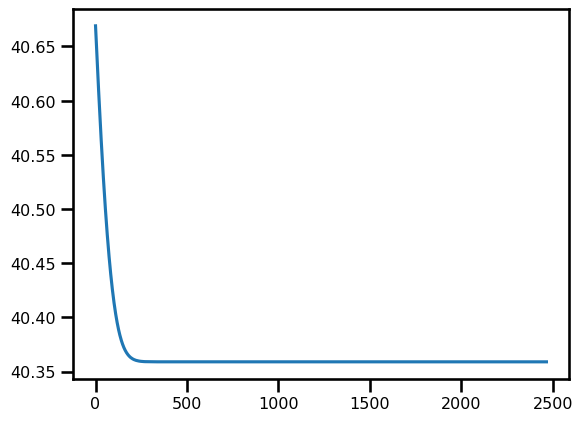

In [44]:
plt.plot(losses)

In [45]:
out_batches = jax.vmap(model, in_axes=(0,0))(x_state[0, :-1], ts_patches)
out_batches.shape, ts_state.shape

((199, 1, 3), (200,))

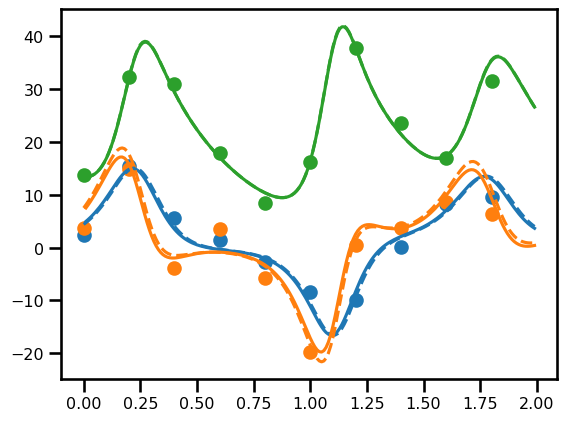

In [46]:
fig, ax = plt.subplots()

ax.plot(ts_state[1:], out_batches[..., 0].squeeze(), linestyle="-", color="tab:blue")
ax.plot(ts_state, x_state[0,..., 0].squeeze(), linestyle="--", color="tab:blue")
ax.scatter(ts_state, y_gt[0,..., 0], color="tab:blue")
ax.plot(ts_state[1:], out_batches[..., 1].squeeze(), linestyle="-", color="tab:orange")
ax.plot(ts_state, x_state[0,..., 1].squeeze(), linestyle="--", color="tab:orange")
ax.scatter(ts_state, y_gt[0,..., 1], color="tab:orange")
ax.plot(ts_state[1:], out_batches[..., 2].squeeze(), linestyle="-", color="tab:green")
ax.plot(ts_state, x_state[0,..., 2].squeeze(), linestyle="--", color="tab:green")
ax.scatter(ts_state, y_gt[0,..., 2],  color="tab:green")

In [47]:
jax.nn.softplus(model.model.sigma), jax.nn.softplus(model.model.rho), jax.nn.softplus(model.model.beta)

(Array(20., dtype=float32, weak_type=True),
 Array(15., dtype=float32, weak_type=True),
 Array(2.6751595, dtype=float32))